# Part A

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

In [3]:
emails = pd.read_csv("enron_practical_sample.csv")
emails

,text,label
0,"hello scott ,\r\nyour request is complete as f...",ham
1,this will clear your inbox\r\nof spam and porn...,spam
2,team :\r\nwe are fast approaching our june 1 d...,ham
3,here are the current issues related to var and...,ham
4,"to all women ,\r\nif your not satisfied with y...",spam
...,...,...
1995,thanks for clarifying that vince .\r\nvince j ...,ham
1996,- - - - - - - - - - - - - - - - - - - - - - - ...,ham
1997,greetings\r\nintruducing m i\r\nenjoy these gr...,spam
1998,"yes , i sent a reply to gillian .\r\n- - stinson",ham


In [4]:
train_text_df, test_text_df = train_test_split(emails, test_size=0.2)

train_labels = train_text_df['label']
train_text = train_text_df['text']

test_labels = test_text_df['label']
test_text = test_text_df['text']

In [5]:
test_text.iloc[0]

"early christmas gift\r\ncomplimentary 3 - session conference pass ( valued at $ 500 ) & 30 % off day passes\r\n100 toronto raptors tickets and rim blackberry will be given away on - site !\r\nnovember 18 19 , 2004\r\nnational trade centre at exhibition place , toronto , canada\r\nefworldexpo . wowgao . com\r\ndear george ,\r\non behalf of the event chair , dr . frank gao , keynote speakers and our sponsors : financial times , national post , sas america , mellon financial , and kofax , we are pleased to invite you to attend at this year ' s e - financial worldexpo , on november 18 & 19 , 2004 .\r\nto acknowledge and show appreciation for relationships and communications from past events and on behalf of the event sponsors , we offer you this exclusive invitation .\r\nregistration\r\n1 . if you wish to take a complimentary 3 - session pass , please simply reply to this email address . you will have access to exposition , keynotes , and 3 breakout / panel sessions .\r\n2 . to take a spe

In [6]:
vectoriser = TfidfVectorizer(stop_words="english", ngram_range=(2, 4), min_df=5, max_df=0.9)
X_train = vectoriser.fit_transform(train_text)

In [7]:
# Vocabulary size
vocab_size = len(vectoriser.vocabulary_)
print(f"Vocabulary size: {vocab_size}")

# Top 10 weighted terms (highest IDF scores)
idf_series = pd.Series(vectoriser.idf_, index=vectoriser.get_feature_names_out())
top_10_terms = idf_series.nlargest(10)
print("\nTop 10 weighted terms:")
print(top_10_terms)

Vocabulary size: 4239

Top 10 weighted terms:
00 10          6.586624
000 cash       6.586624
000 company    6.586624
000 day        6.586624
000 little     6.586624
000 loan       6.586624
000 people     6.586624
01 01          6.586624
01 10          6.586624
01 11          6.586624
dtype: float64


# Part B

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
import umap
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Combine all text for visualization
all_text = pd.concat([train_text, test_text])
all_labels = pd.concat([train_labels, test_labels])

# Vectorize with moderate feature budget
vectoriser = TfidfVectorizer(max_features=1000, stop_words="english")
X_tfidf = vectoriser.fit_transform(all_text)

# Reduce to 2D with UMAP
reducer = umap.UMAP(n_components=2, random_state=2025, n_neighbors=50, metric='cosine')
embedding = reducer.fit_transform(X_tfidf)

C:\Users\ryanw\Documents\GitHub\Uni-Work\MRes\Teaching\comp-wk10\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


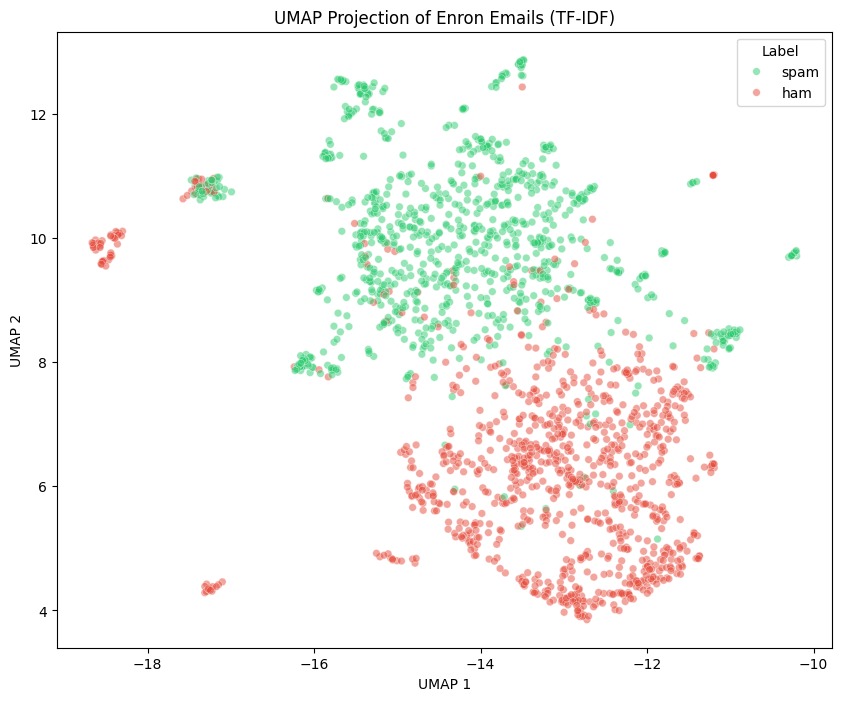

In [10]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=all_labels, palette=["#2ecc71", "#e74c3c"], alpha=0.5, s=30)
plt.title("UMAP Projection of Enron Emails (TF-IDF)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Label")
plt.show()

# Part C

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

In [12]:
pipeline = Pipeline([("vectoriser", TfidfVectorizer(max_features=1000, stop_words="english", min_df=5, max_df=0.8, ngram_range=(1, 2))),
                     ("model", LogisticRegression(max_iter=500))])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2025)

metrics = cross_validate(pipeline, train_text, train_labels,
                         cv=cv, scoring=["accuracy", "f1_macro"],
                         return_train_score=True)
metrics

{'fit_time': array([0.59804988, 0.61066699, 0.62719917, 0.55638957, 0.55797029]),
 'score_time': array([0.05327654, 0.05497146, 0.04734921, 0.06911421, 0.06292152]),
 'test_accuracy': array([0.959375, 0.965625, 0.95625 , 0.953125, 0.975   ]),
 'train_accuracy': array([0.97890625, 0.98203125, 0.98046875, 0.9828125 , 0.9734375 ]),
 'test_f1_macro': array([0.9593746 , 0.96561661, 0.95623461, 0.95310256, 0.97499609]),
 'train_f1_macro': array([0.97890521, 0.98203098, 0.98046864, 0.98281233, 0.97343432])}

In [13]:
print(metrics["test_f1_macro"].mean() )
print(metrics["test_accuracy"].mean())

0.9618648949193584
0.9618749999999998


In [14]:
pipeline.fit(train_text, y=train_labels)

,steps,"[('vectoriser', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [15]:
predictions = pipeline.predict(test_text)

probabilities = pipeline.predict_proba(test_text)

acc = pipeline.score(test_text, y=test_labels, scoring='accuracy')
f1 = pipeline.score(test_text, y=test_labels, scoring='f1_macro')

confusion_matrix(test_labels, predictions)

array([[177,  13],
       [  2, 208]])

# Part D

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import Bunch
import numpy as np

best_params = {
    "max_features": 1000,
    "stop_words": "english",
    "min_df": 5, 
    "max_df": 0.8, 
    "ngram_range": (1, 2)
}

# eg_list = [1, 2, 5, 6]
# eg_list[2]

# eg_dict = {'apple': 1, 'pasta': 2, 'banana': 5, 'cheese': 6}
# eg_dict['banana']

In [17]:
def train_with_c(C=1.0, penalty="l2") -> Bunch:
    pipeline = Pipeline([("vectoriser", TfidfVectorizer(**best_params)),
                         ("model", LogisticRegression(max_iter=1000, C=C, penalty=penalty,
                                                      solver="liblinear" if penalty == "l1" else "lbfgs"))])
    
    pipeline.fit(train_text, train_labels)
    return Bunch(pipeline=pipeline,
                 coefficients=pipeline.named_steps["model"].coef_[0],
                 vocab=pipeline.named_steps["vectoriser"].get_feature_names_out())


In [18]:
C_trials = [0.1, 1, 10, 1]
penalties = ['l2', 'l2', 'l2', 'l1']

plot_labels = ['C=0.1\np=l2', 'C=1\np=l2', 'C=10\np=l2', 'C=1\np=l1']

bunches = []

for i, [c, penalty] in enumerate(zip(C_trials, penalties)):
    print(i)
    bunches.append(train_with_c(C=c, penalty=penalty))

0
1
2
3


In [19]:
bunches[0]

{'pipeline': Pipeline(steps=[('vectoriser',
                  TfidfVectorizer(max_df=0.8, max_features=1000, min_df=5,
                                  ngram_range=(1, 2), stop_words='english')),
                 ('model', LogisticRegression(C=0.1, max_iter=1000))]),
 'coefficients': array([-1.90632258e-01,  3.23470197e-03,  9.40854214e-02,  8.58294286e-02,
        -1.56280614e-01, -3.90938424e-01, -7.74718513e-03, -2.61653963e-01,
        -1.51572998e-01, -1.93745356e-01, -6.60217958e-02, -1.73177741e-01,
        -7.54685355e-02, -1.11948741e-01, -1.53600388e-01, -5.54676104e-02,
        -1.79747282e-01,  1.91151235e-02,  1.09476284e-03,  2.94543200e-01,
        -2.98287310e-01, -8.48848004e-02, -3.93084750e-01, -1.49212387e-01,
        -1.14259496e-01, -1.00350216e-01, -1.54690682e-01, -9.96364795e-02,
        -1.54967473e-03, -3.76604804e-02, -5.22680567e-03, -3.89650619e-02,
        -2.01486533e-02,  7.72206091e-02, -5.87351350e-01, -1.94680387e-02,
        -8.72787054e-01, -1.168

enron


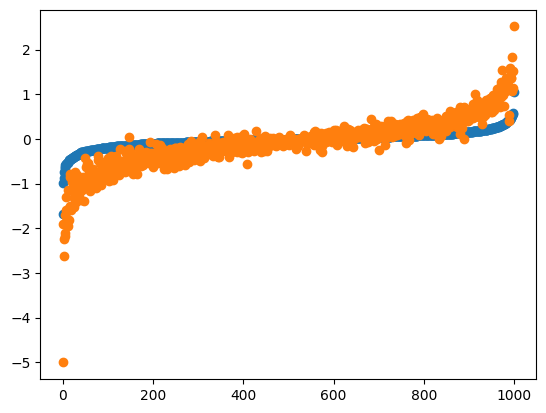

In [32]:
fig, ax = plt.subplots()

# first iter: C = 0.1, penalty = l2 - blue
# second iter: C = 1, penalty = l2 - orange

for i in range(2):
    ydata = bunches[i]['coefficients']

    if i == 0:
        sort_inds = np.argsort(ydata)
    # sort_inds = np.argsort(ydata)
    
    plt.scatter(np.arange(1000), ydata[sort_inds])

print(bunches[0]['vocab'][sort_inds[0]])

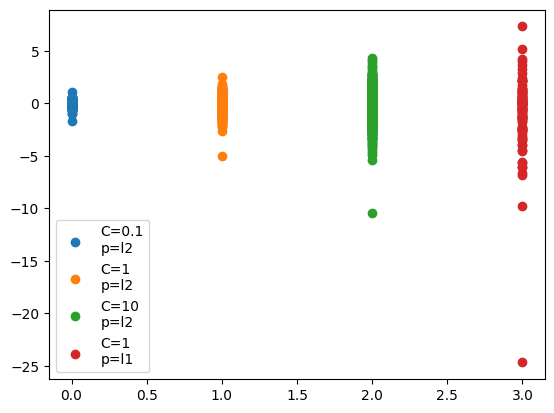

In [21]:
fig, ax = plt.subplots()

for i in range(4):
    ax.scatter(i * np.ones(1000), bunches[i]['coefficients'], label=plot_labels[i])
ax.legend()

In [22]:
winner = bunches[-1]

In [23]:
sorted_inds = np.argsort(winner['coefficients']).flatten()

lowest_inds = sorted_inds[:5]
highest_inds = sorted_inds[-5:]

lowest_coeffs = winner['coefficients'][lowest_inds]
lowest_values = winner['vocab'][lowest_inds]

highest_coeffs = winner['coefficients'][highest_inds]
highest_values = winner['vocab'][highest_inds]

print(lowest_coeffs, lowest_values)
print(highest_coeffs, highest_values)

[-24.67393142  -9.78237713  -6.8055067   -6.58720105  -6.07540269] ['enron' '2001' 'thanks' 'let know' 'vince']
[3.63609819 4.07579297 4.22568076 5.18446886 7.32210896] ['company' 'stop' '2005' 'money' 'http']


# Part E

In [24]:
probabilities

array([[0.27756627, 0.72243373],
       [0.13677365, 0.86322635],
       [0.94459999, 0.05540001],
       [0.95482725, 0.04517275],
       [0.07150951, 0.92849049],
       [0.22912591, 0.77087409],
       [0.2150008 , 0.7849992 ],
       [0.98661323, 0.01338677],
       [0.68838387, 0.31161613],
       [0.928323  , 0.071677  ],
       [0.09021864, 0.90978136],
       [0.98730902, 0.01269098],
       [0.97856986, 0.02143014],
       [0.02991672, 0.97008328],
       [0.07455443, 0.92544557],
       [0.78839902, 0.21160098],
       [0.79113976, 0.20886024],
       [0.07269579, 0.92730421],
       [0.3925949 , 0.6074051 ],
       [0.74245389, 0.25754611],
       [0.185035  , 0.814965  ],
       [0.24722767, 0.75277233],
       [0.73947152, 0.26052848],
       [0.2440087 , 0.7559913 ],
       [0.80761041, 0.19238959],
       [0.12464295, 0.87535705],
       [0.09196477, 0.90803523],
       [0.12893449, 0.87106551],
       [0.24841081, 0.75158919],
       [0.13191325, 0.86808675],
       [0.

In [25]:
misclass_inds = predictions != test_labels.values

prob_spam = np.array(probabilities[misclass_inds])[:, 1]

misclassifications = pd.DataFrame({'text': test_text[misclass_inds],
                                  'true_label': test_labels.values[misclass_inds],
                                  'predicted': predictions[misclass_inds],
                                  'probability': prob_spam}).reset_index()
misclassifications

,index,text,true_label,predicted,probability
0,1084,),ham,spam,0.607405
1,1086,congratulations on your promotion to md !\r\nalan,ham,spam,0.607405
2,655,arrestor interface volcanos transcend\r\nfanou...,spam,ham,0.420065
3,33,"meridia , celebrex , dar , von , ultram , viox...",spam,ham,0.484283
4,63,"hi all ,\r\ni just got off the phone with the ...",ham,spam,0.587754
5,129,"hello , vince .\r\nwe still have the 2 other b...",ham,spam,0.596784
6,1449,jo hillier - smith\r\nowner care manager\r\nsu...,ham,spam,0.585935
7,1714,"as mentioned , we ' ll drop in the revised com...",ham,spam,0.598920
8,937,kal came up with a couple of suggestions :\r\n...,ham,spam,0.669850
9,643,here a preliminary list of items that need our...,ham,spam,0.614651
